Model Building - Base Model

In [1]:
import pandas as pd
import joblib

import warnings

warnings.filterwarnings("ignore")

from afl_match_outcome_model.config import match_summary_file_path
from afl_match_outcome_model.data_preparation.match_summary_preprocessor import MatchSummaryPreprocessor

from afl_match_outcome_model.modelling_data_contract import ModellingDataContract
from afl_match_outcome_model.modelling.hyperparameter_tuning import (
    XGBHyperparameterTuner,
)
from afl_match_outcome_model.modelling.supermodel import SuperXGBClassifier
from afl_match_outcome_model.modelling.optuna_xgb_param_grid import OptunaXGBParamGrid

from afl_match_outcome_model.evaluation.model_evaluation import XGBClassifierEvaluator


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
RESPONSE = ModellingDataContract.RESPONSE

Load Data

In [3]:
data = pd.read_csv(match_summary_file_path)
data.tail()

,Home_Team,Away_Team,Q4_Score,Margin,Total Game Score,Home Win,Venue,City,Date,Attendance,Temperature,Weather_Type,Year,Round_ID,Match_ID,Season
4669,Melbourne,Carlton,9.17.71 - 11.7.73,-2,144,0.0,M.C.G.,Melbourne,2023-09-15 19:50:00,0,23.0,WINDY,2023,2023F2,2023F2_Melbourne_Carlton,2023.0
4670,Port Adelaide,Greater Western Sydney,9.16.70 - 13.15.93,-23,163,0.0,Adelaide Oval,Adelaide,2023-09-16 19:40:00,0,18.0,MOSTLY_SUNNY,2023,2023F2,2023F2_PortAdelaide_GreaterWesternSydney,2023.0
4671,Brisbane Lions,Carlton,11.13.79 - 9.9.63,16,142,1.0,Gabba,Brisbane,2023-09-23 17:15:00,0,23.0,MOSTLY_SUNNY,2023,2023F3,2023F3_BrisbaneLions_Carlton,2023.0
4672,Collingwood,Greater Western Sydney,8.10.58 - 8.9.57,1,115,1.0,M.C.G.,Melbourne,2023-09-22 19:50:00,0,16.0,MOSTLY_SUNNY,2023,2023F3,2023F3_Collingwood_GreaterWesternSydney,2023.0
4673,Collingwood,Brisbane Lions,12.18.90 - 13.8.86,4,176,1.0,M.C.G.,Melbourne,2023-09-29 14:30:00,0,29.0,SUNNY,2023,2023F4,2023F4_Collingwood_BrisbaneLions,2023.0


Preprocessing

In [4]:
match_preprocessor = MatchSummaryPreprocessor(
    categorical_features=['Venue', 'City', 'Opponent' ,'Team'],
    rolling_cols=['Team_Score', 'Opp_Score', 'Team_Goals', 'Opp_Goals'],
    rolling=[1, 3, 5, 10, 20],
    extra_features=['Home']
)
match_preprocessor.fit(data)

MatchSummaryPreprocessor(categorical_features=['Venue', 'City', 'Opponent',
                                               'Team'],
                         extra_features=['Home'], rolling=[1, 3, 5, 10, 20],
                         rolling_cols=['Team_Score', 'Opp_Score', 'Team_Goals',
                                       'Opp_Goals'])

In [5]:
X = match_preprocessor.transform(data)
X.tail()

,Home,Team_Score_rolling_1,Opp_Score_rolling_1,Team_Goals_rolling_1,Opp_Goals_rolling_1,Team_Score_rolling_3,Opp_Score_rolling_3,Team_Goals_rolling_3,Opp_Goals_rolling_3,Team_Score_rolling_5,Opp_Score_rolling_5,Team_Goals_rolling_5,Opp_Goals_rolling_5,Team_Score_rolling_10,Opp_Score_rolling_10,Team_Goals_rolling_10,Opp_Goals_rolling_10,Team_Score_rolling_20,Opp_Score_rolling_20,Team_Goals_rolling_20,Opp_Goals_rolling_20,Venue_Adelaide Oval,Venue_Bellerive Oval,Venue_Blacktown,Venue_Carrara,Venue_Cazalys Stadium,Venue_Docklands,Venue_Eureka Stadium,Venue_Football Park,Venue_Gabba,Venue_Jiangwan Stadium,Venue_Kardinia Park,Venue_M.C.G.,Venue_Manuka Oval,Venue_Marrara Oval,Venue_Norwood Oval,Venue_Perth Stadium,Venue_Princes Park,Venue_Riverway Stadium,Venue_S.C.G.,Venue_Stadium Australia,Venue_Subiaco,Venue_Sydney Showground,Venue_Traeger Park,Venue_Wellington,Venue_York Park,City_Adelaide,City_Alice Springs,City_Ballarat,City_Brisbane,City_Cairns,City_Canberra,City_Darwin,City_Geelong,City_Gold Coast,City_Hobart,City_Launceston,City_Melbourne,City_Perth,City_Shanghai,City_Sydney,City_Townsville,City_Wellington,Opponent_Adelaide,Opponent_Brisbane Lions,Opponent_Carlton,Opponent_Collingwood,Opponent_Essendon,Opponent_Fremantle,Opponent_Geelong,Opponent_Gold Coast,Opponent_Greater Western Sydney,Opponent_Hawthorn,Opponent_Melbourne,Opponent_North Melbourne,Opponent_Port Adelaide,Opponent_Richmond,Opponent_St Kilda,Opponent_Sydney,Opponent_West Coast,Opponent_Western Bulldogs,Team_Adelaide,Team_Brisbane Lions,Team_Carlton,Team_Collingwood,Team_Essendon,Team_Fremantle,Team_Geelong,Team_Gold Coast,Team_Greater Western Sydney,Team_Hawthorn,Team_Melbourne,Team_North Melbourne,Team_Port Adelaide,Team_Richmond,Team_St Kilda,Team_Sydney,Team_West Coast,Team_Western Bulldogs
8641,1,90.0,49.0,13.0,7.0,81.000000,72.000000,11.666667,10.333333,90.0,74.6,13.2,11.0,85.1,76.0,12.2,11.2,80.70,75.8,11.50,11.10,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
8642,1,73.0,78.0,10.0,11.0,79.666667,68.333333,11.333333,9.666667,83.6,73.4,12.2,10.6,84.5,77.9,12.1,11.5,80.00,76.5,11.40,11.15,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
8643,0,126.0,71.0,19.0,10.0,96.333333,66.000000,14.000000,9.333333,88.4,73.0,12.8,10.4,88.6,81.0,12.9,12.0,83.30,76.4,11.95,11.10,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
8644,1,64.0,67.0,9.0,9.0,87.666667,72.000000,12.666667,10.000000,85.8,68.6,12.4,9.6,87.3,79.3,12.7,11.6,83.25,74.0,11.95,10.70,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [6]:
y = match_preprocessor.get_response(data)

In [7]:
y.value_counts(normalize=True)

Result
1    0.504048
0    0.495952
Name: proportion, dtype: float64

Train / Test Split

In [8]:
X.shape, y.shape

((8646, 99), (8646,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2407, stratify=y
)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, random_state=2407, stratify=y_train
)

In [10]:
y_train.value_counts(), y_test.value_counts(), y_cal.value_counts()

(Result
 1    2788
 0    2744
 Name: count, dtype: int64,
 Result
 1    872
 0    858
 Name: count, dtype: int64,
 Result
 1    698
 0    686
 Name: count, dtype: int64)

In [11]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True), y_cal.value_counts(normalize=True)

(Result
 1    0.503977
 0    0.496023
 Name: proportion, dtype: float64,
 Result
 1    0.504046
 0    0.495954
 Name: proportion, dtype: float64,
 Result
 1    0.504335
 0    0.495665
 Name: proportion, dtype: float64)

In [12]:
y.mean(), y_train.mean(), y_test.mean(), y_cal.mean()

(0.5040481147351377,
 0.5039768618944324,
 0.5040462427745664,
 0.5043352601156069)

Optuna Hyperparameter Tuning Class - HyperParameterTuner & XGBHyperparameterTuner

In [13]:
xgb_tuner = XGBHyperparameterTuner(
    X_train, y_train, monotonicity_constraints={}
)

In [14]:
xgb_tuner.tune_hyperparameters()

[I 2024-01-12 22:05:09,522] A new study created in memory with name: no-name-015cf647-7e94-4c2b-83a8-55e462887ffe
[I 2024-01-12 22:05:09,646] Trial 0 finished with value: 0.684889027033058 and parameters: {'max_depth': 7, 'min_child_weight': 32, 'eta': 0.013726888572964769, 'gamma': 0.020488980489840367, 'lambda': 0.00041719927123601, 'alpha': 0.0016501626881591472, 'subsample': 0.8556782786004788, 'colsample_bytree': 0.4902573928021452}. Best is trial 0 with value: 0.684889027033058.
[I 2024-01-12 22:05:09,768] Trial 1 finished with value: 0.6723363693413417 and parameters: {'max_depth': 16, 'min_child_weight': 35, 'eta': 0.2566922132660173, 'gamma': 0.45154921900130957, 'lambda': 0.011866749735393358, 'alpha': 0.0014860949524018291, 'subsample': 0.7147342035767386, 'colsample_bytree': 0.4719512827334883}. Best is trial 1 with value: 0.6723363693413417.
[I 2024-01-12 22:05:09,885] Trial 2 finished with value: 0.6761899451242532 and parameters: {'max_depth': 18, 'min_child_weight': 18,

Number of finished trials:  100
Best trial:
  Value: 0.6428144471621619
  Params: 
    max_depth: 7
    min_child_weight: 32
    eta: 0.2644809934485454
    gamma: 0.0006707488882121399
    lambda: 0.04649687994014046
    alpha: 0.057661223455387677
    subsample: 0.8571512782858475
    colsample_bytree: 0.881149256237845


In [15]:
params = xgb_tuner.get_best_params()
params

{'max_depth': 7,
 'min_child_weight': 32,
 'eta': 0.2644809934485454,
 'gamma': 0.0006707488882121399,
 'lambda': 0.04649687994014046,
 'alpha': 0.057661223455387677,
 'subsample': 0.8571512782858475,
 'colsample_bytree': 0.881149256237845}

Training Model - SuperXGBClassifier class for training and predictions

In [16]:
params["objective"] = OptunaXGBParamGrid.error
params["num_rounds"] = 1000
params["early_stopping_rounds"] = 10
params["verbosity"] = 1
params["monotone_constraints"] = {}

In [17]:
super_xgb = SuperXGBClassifier(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_cal=X_cal,
    y_cal=y_cal,
    params=params,
)

In [18]:
super_xgb.fit()

[0]	validation_0-logloss:0.67116	validation_1-logloss:0.67173
[1]	validation_0-logloss:0.65735	validation_1-logloss:0.65977
[2]	validation_0-logloss:0.64683	validation_1-logloss:0.65317
[3]	validation_0-logloss:0.63837	validation_1-logloss:0.64654
[4]	validation_0-logloss:0.63157	validation_1-logloss:0.64301
[5]	validation_0-logloss:0.62456	validation_1-logloss:0.63660
[6]	validation_0-logloss:0.62111	validation_1-logloss:0.63406
[7]	validation_0-logloss:0.61610	validation_1-logloss:0.63019
[8]	validation_0-logloss:0.61296	validation_1-logloss:0.62893
[9]	validation_0-logloss:0.60999	validation_1-logloss:0.62700
[10]	validation_0-logloss:0.60698	validation_1-logloss:0.62611
[11]	validation_0-logloss:0.60423	validation_1-logloss:0.62558
[12]	validation_0-logloss:0.60268	validation_1-logloss:0.62531
[13]	validation_0-logloss:0.60014	validation_1-logloss:0.62515
[14]	validation_0-logloss:0.59734	validation_1-logloss:0.62598
[15]	validation_0-logloss:0.59541	validation_1-logloss:0.62612
[1

In [19]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.881149256237845, device=None,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0006707488882121399,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2644809934485454,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=32, missing=nan, monotone_constraints={},
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
super_xgb.calibrate()

In [21]:
preds = super_xgb.predict(X)
train_preds = super_xgb.predict(X_train)
test_preds = super_xgb.predict(X_test)

In [22]:
probas = super_xgb.predict_proba(X)[:, 1]
train_probas = super_xgb.predict_proba(X_train)[:, 1]
test_probas = super_xgb.predict_proba(X_test)[:, 1]
cal_probas = super_xgb.predict_proba(X_cal)[:, 1]

In [23]:
cal_probas = super_xgb.predict_proba(X, calibrate=True)
train_cal_probas = super_xgb.predict_proba(X_train, calibrate=True)
test_cal_probas = super_xgb.predict_proba(X_test, calibrate=True)
cal_cal_probas = super_xgb.predict_proba(X_cal, calibrate=True)

Check Average Predictions

In [24]:
y.mean(), probas.mean(), cal_probas.mean()

(0.5040481147351377, 0.5040679, 0.5044772451203523)

In [25]:
y_train.mean(), train_probas.mean(), train_cal_probas.mean()

(0.5039768618944324, 0.5028623, 0.503357488678499)

In [26]:
y_test.mean(), test_probas.mean(), test_cal_probas.mean()

(0.5040462427745664, 0.508084, 0.5081718446709608)

In [27]:
y_cal.mean(), cal_probas.mean(), cal_cal_probas.mean()

(0.5043352601156069, 0.5044772451203523, 0.50433478515921)

Model Evaluation

In [28]:
training_data = pd.concat([X_train, y_train], axis=1)
training_data["xgb_preds"] = train_preds
training_data["xgb_probas"] = train_probas
training_data["xgb_cal_probas"] = train_cal_probas
training_data['baseline'] = y_train.mean()
training_data['baseline_label'] = 1

train_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=training_data,
    actual_name=RESPONSE,
    expected_name="xgb_cal_probas",
    expected_label_name="xgb_preds",
    compare_name="baseline",
    compare_label_name="baseline_label"
)

In [29]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data["xgb_preds"] = test_preds
test_data["xgb_probas"] = test_probas
test_data["xgb_cal_probas"] = test_cal_probas
test_data['baseline'] = y_train.mean()
test_data['baseline_label'] = 1

test_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=test_data,
    actual_name=RESPONSE,
    expected_name="xgb_cal_probas",
    expected_label_name="xgb_preds",
    compare_name="baseline",
    compare_label_name="baseline_label"
)

baseline_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=test_data,
    actual_name=RESPONSE,
    expected_name="baseline",
    expected_label_name="baseline_label",
)


Model Averages

In [30]:
test_data[[RESPONSE, "xgb_probas", "xgb_cal_probas", "baseline_label", "baseline"]].describe()

,Result,xgb_probas,xgb_cal_probas,baseline_label,baseline
count,1730.000000,1730.000000,1730.000000,1730.0,1.730000e+03
mean,0.504046,0.508084,0.508172,1.0,5.039769e-01
std,0.500128,0.158377,0.162347,0.0,1.110544e-16
min,0.000000,0.094169,0.160435,1.0,5.039769e-01
25%,0.000000,0.390492,0.379936,1.0,5.039769e-01
50%,1.000000,0.513828,0.497762,1.0,5.039769e-01
75%,1.000000,0.624267,0.622139,1.0,5.039769e-01
max,1.000000,0.891362,0.939558,1.0,5.039769e-01


Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [31]:
test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.6264
Compare Log-Loss: 	0.6931


(0.6263725585365242, 0.6263725585365242)

In [32]:
test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.2184
Compare Brier Score: 	0.2500


(0.21839498216533393, 0.24998363273311577)

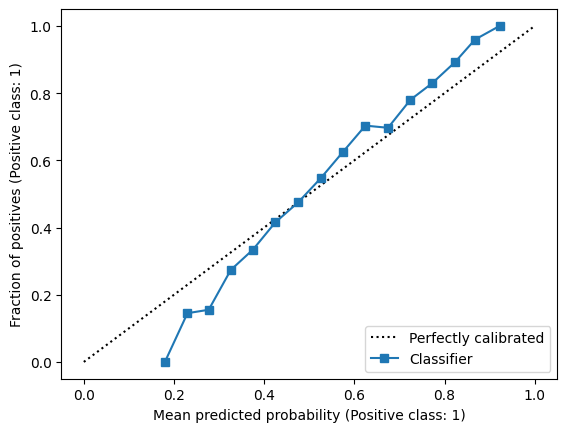

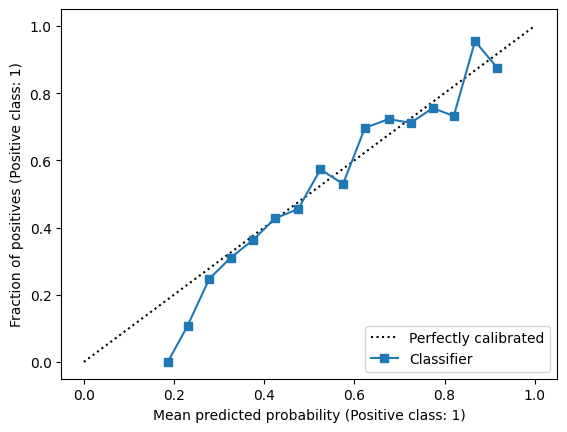

In [33]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)

In [34]:
test_xgb_evals.get_accuracy(), test_xgb_evals.get_recall(), test_xgb_evals.get_precision(), test_xgb_evals.get_f1_score()

Expected Accuracy: 	0.6486
Compare Accuracy: 	0.5040
Expected Recall: 	0.6835
Compare Recall: 	1.0000
Expected Precision: 	0.6422
Compare Precision: 	0.5040
Expected F1 Score: 	0.6622
Compare F1 Score: 	0.6703


((0.6485549132947976, 0.5040462427745664),
 (0.6834862385321101, 1.0),
 (0.6422413793103449, 0.5040462427745664),
 (0.6622222222222222, 0.6702536510376633))

In [35]:
baseline_xgb_evals.get_confusion_matrix(), test_xgb_evals.get_confusion_matrix()

(array([[  0, 858],
        [  0, 872]]),
 array([[526, 332],
        [276, 596]]))

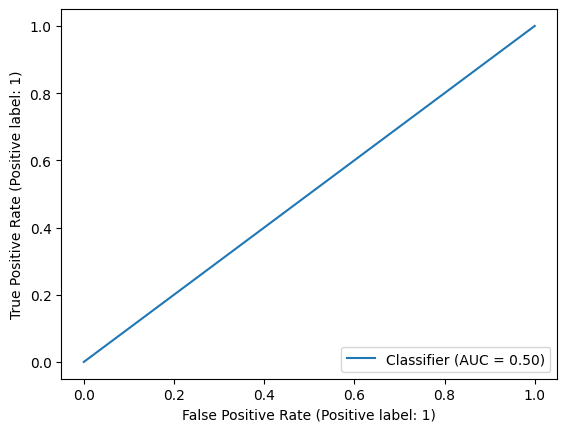

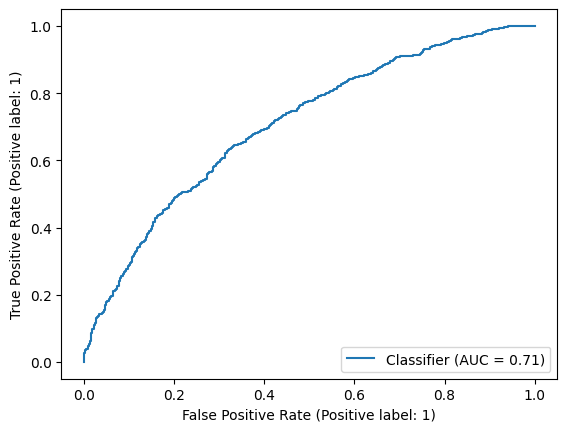

In [36]:
baseline_xgb_evals.plot_roc_curve()
test_xgb_evals.plot_roc_curve()

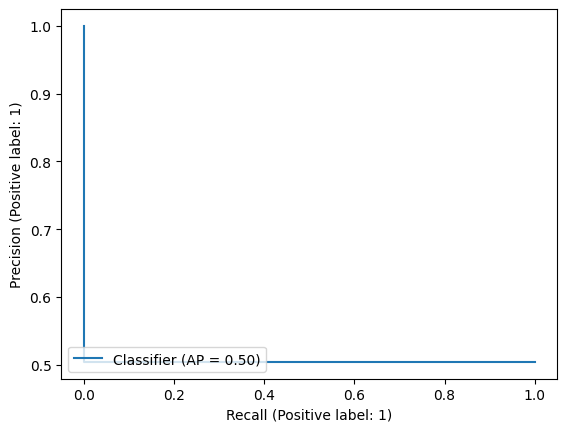

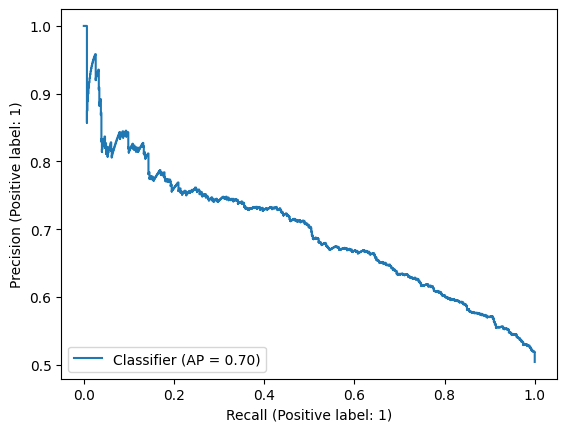

In [37]:
baseline_xgb_evals.plot_prauc_curve()
test_xgb_evals.plot_prauc_curve()

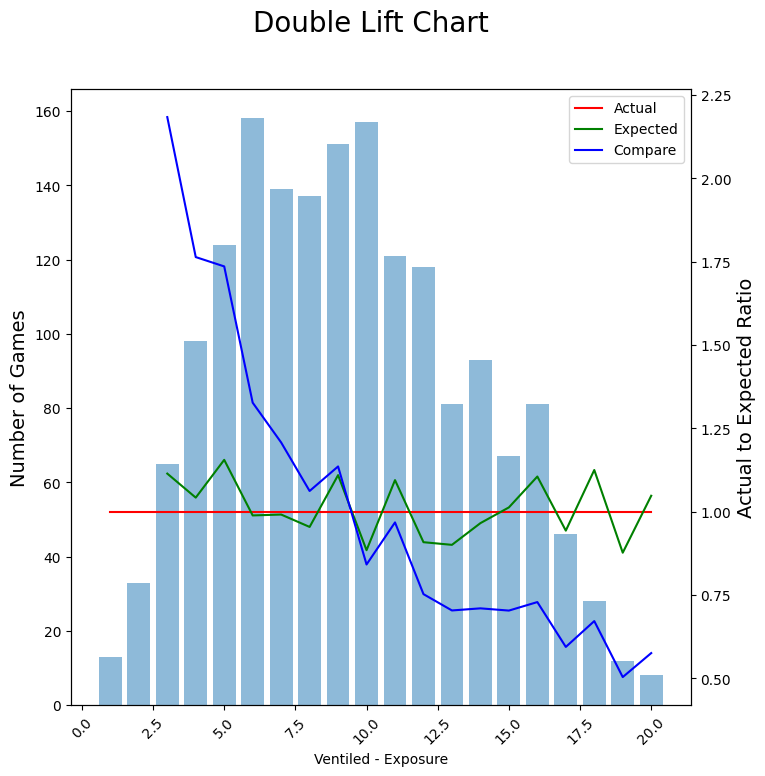

In [38]:
test_xgb_evals.plot_double_lift_chart()

Plots

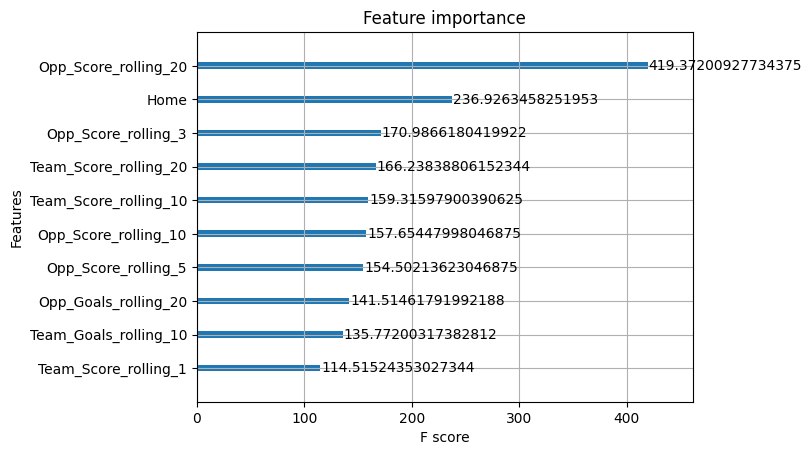

In [39]:
test_xgb_evals.plot_feature_importance(
    max_num_features=10, importance_type="total_gain"
)

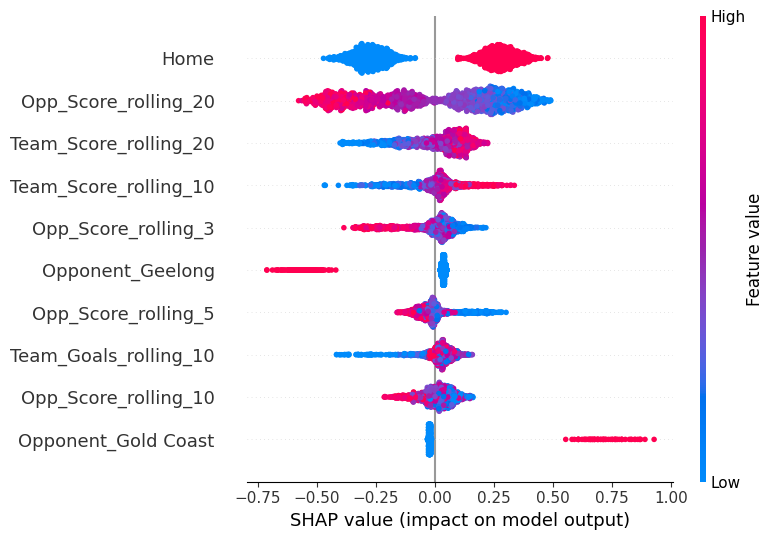

In [40]:
test_xgb_evals.plot_shap_summary_plot(sample=len(X_test))

In [41]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Home',
 'Opp_Score_rolling_20',
 'Team_Score_rolling_20',
 'Team_Score_rolling_10',
 'Opp_Score_rolling_3',
 'Opponent_Geelong',
 'Opp_Score_rolling_5',
 'Team_Goals_rolling_10',
 'Opp_Score_rolling_10',
 'Opponent_Gold Coast']

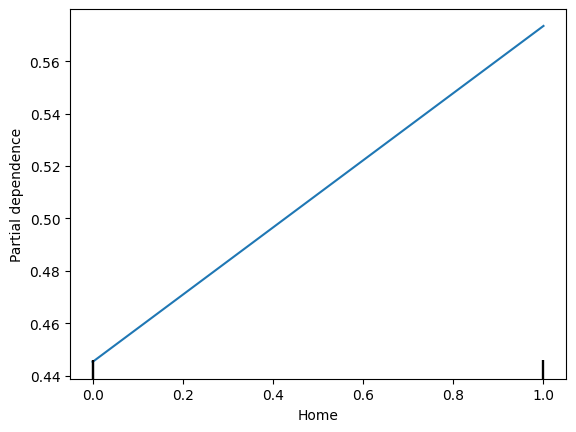

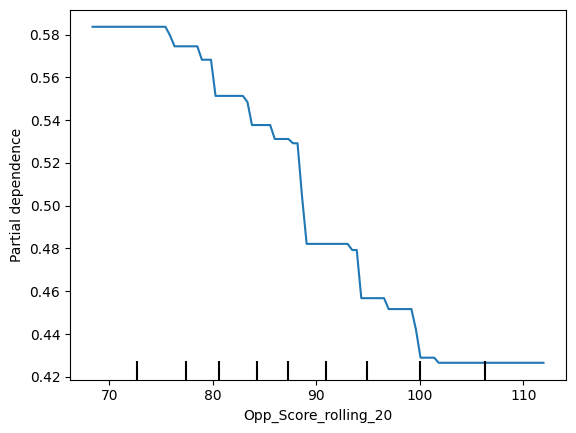

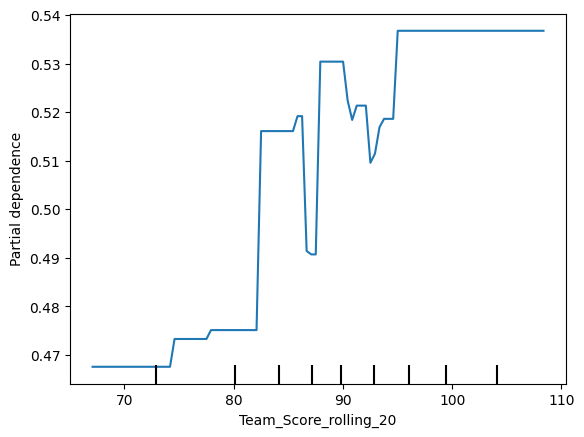

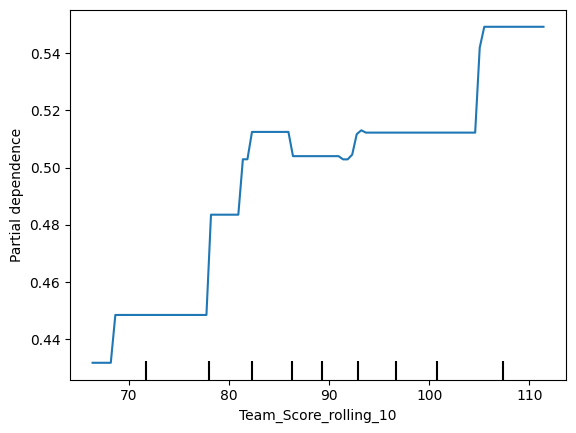

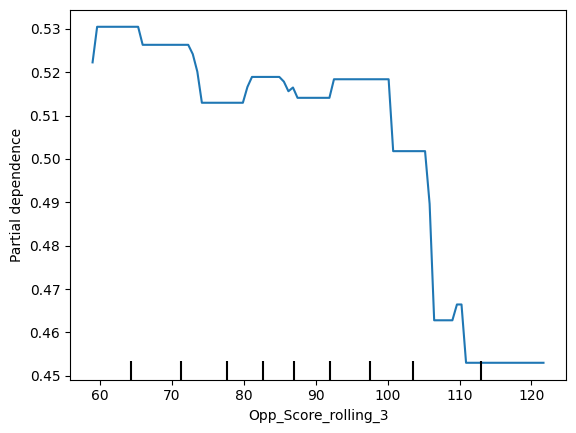

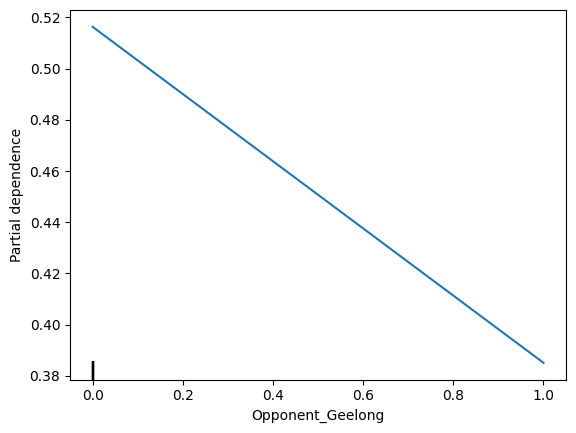

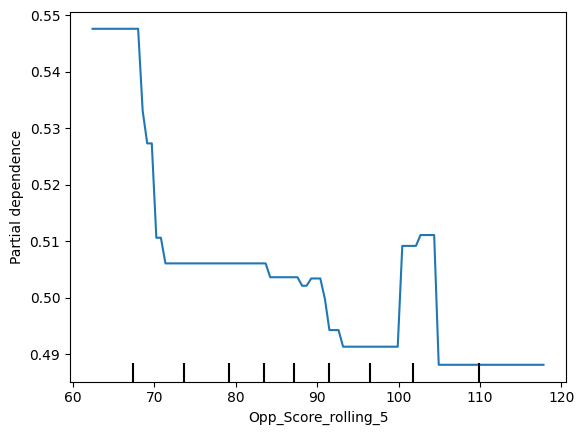

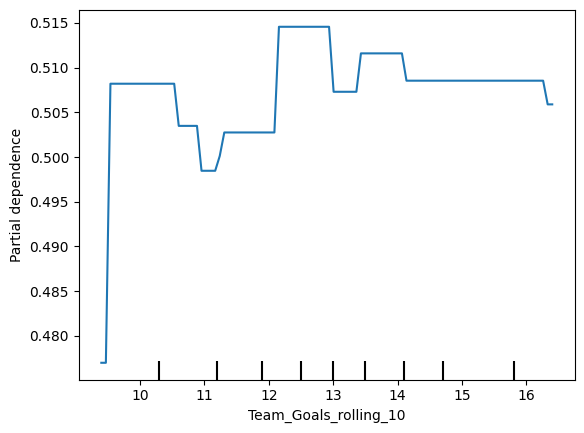

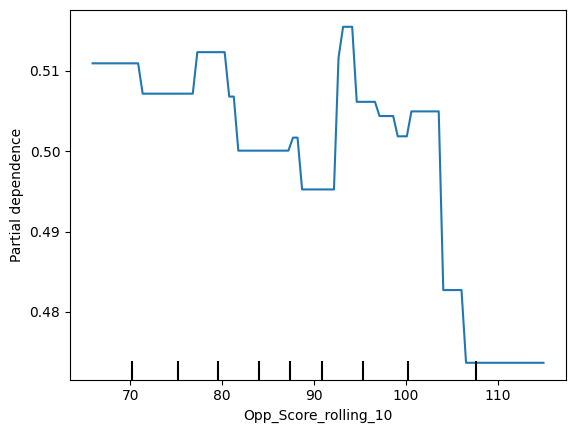

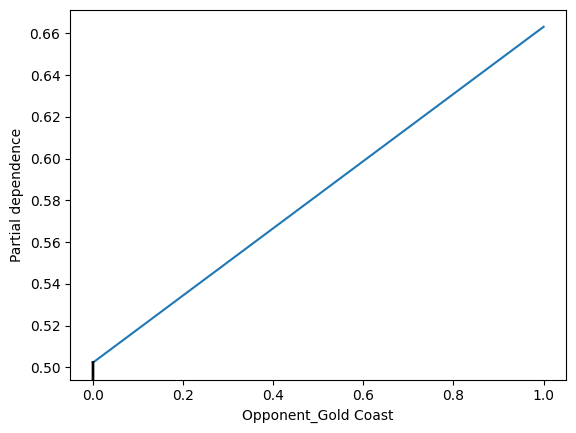

In [42]:
for col in top_10_features:
    # train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

In [43]:
# for col in top_10_features:
#     train_xgb_evals.plot_ice([col])
#     test_xgb_evals.plot_ice([col])

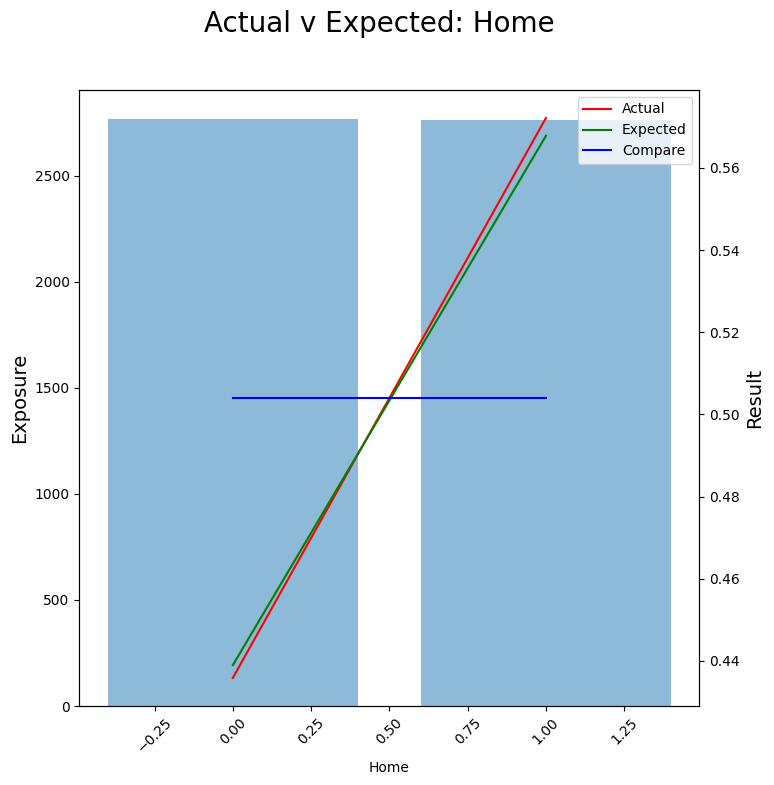

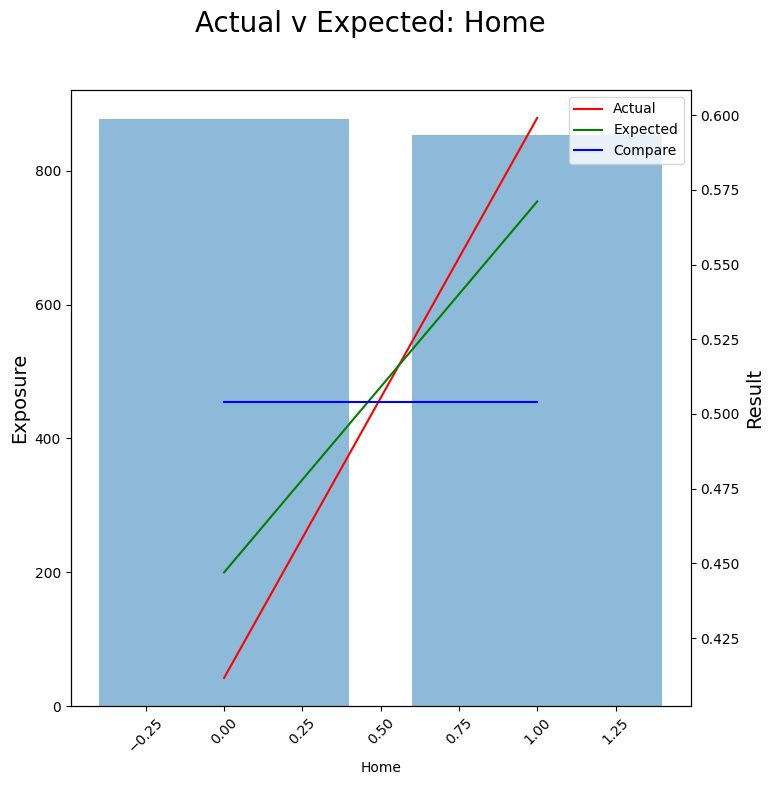

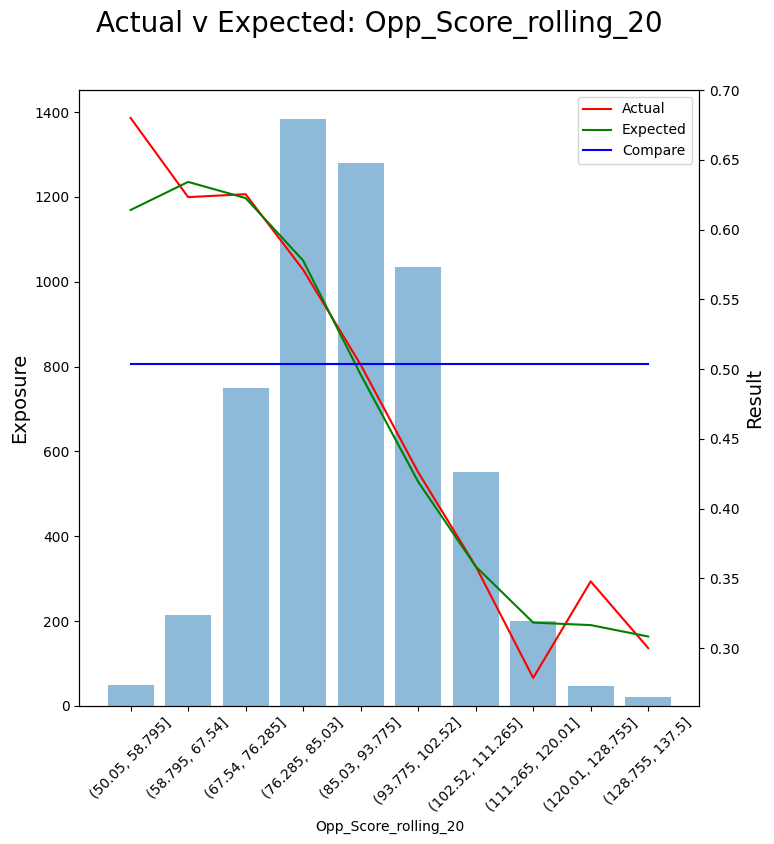

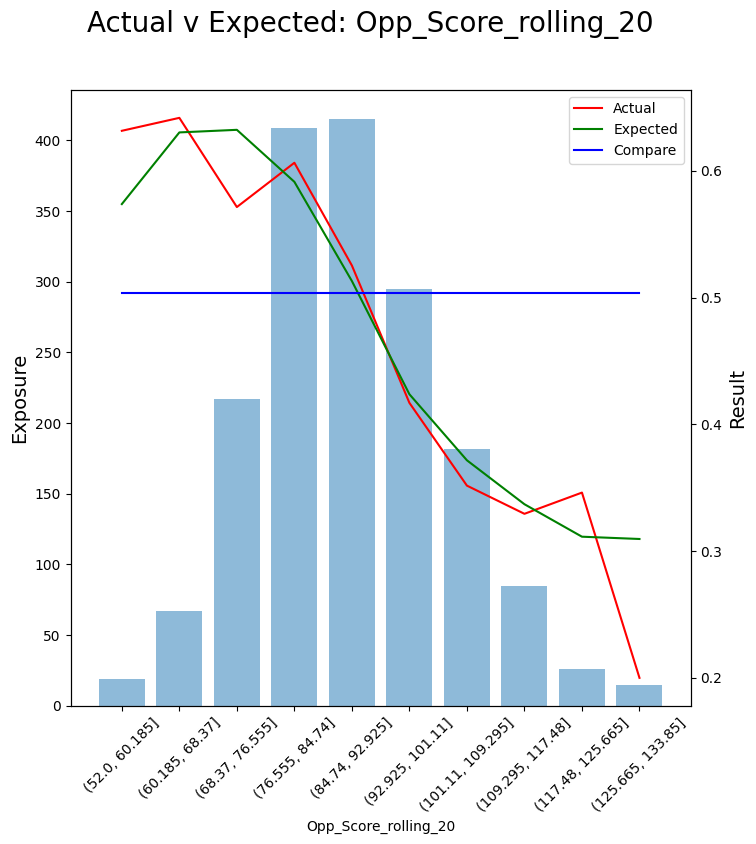

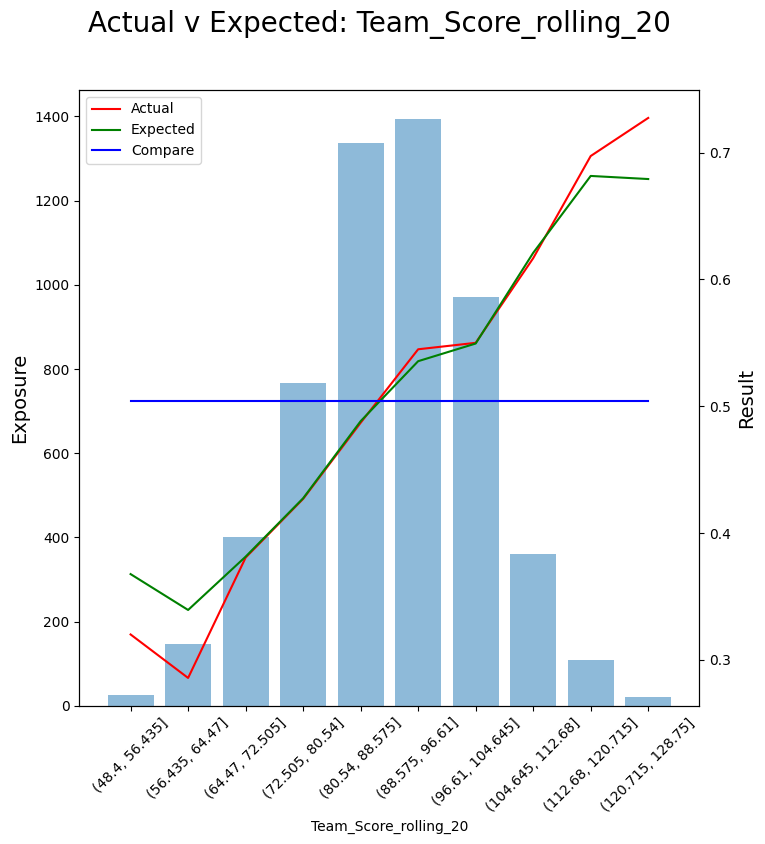

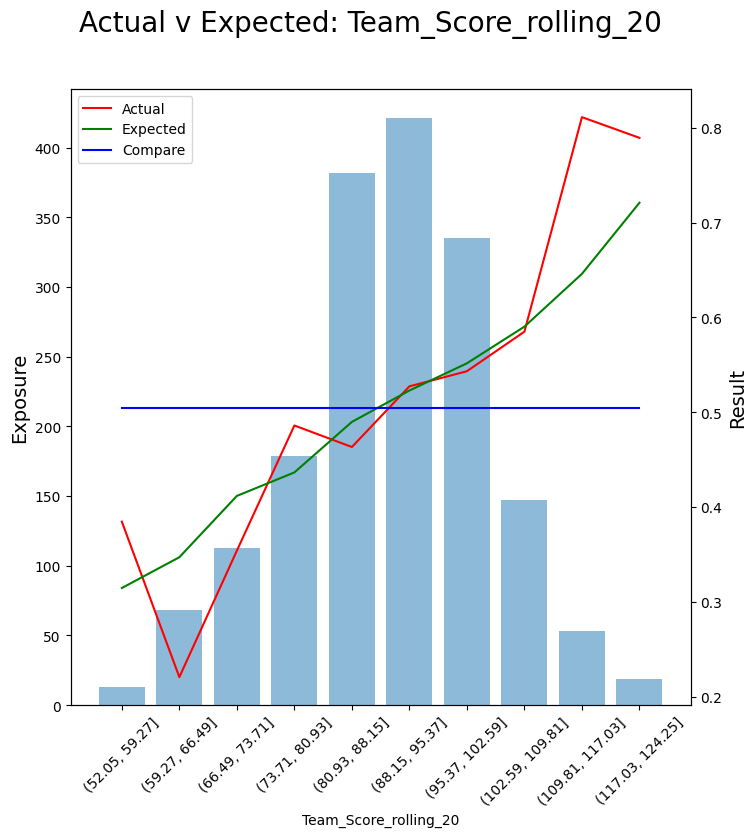

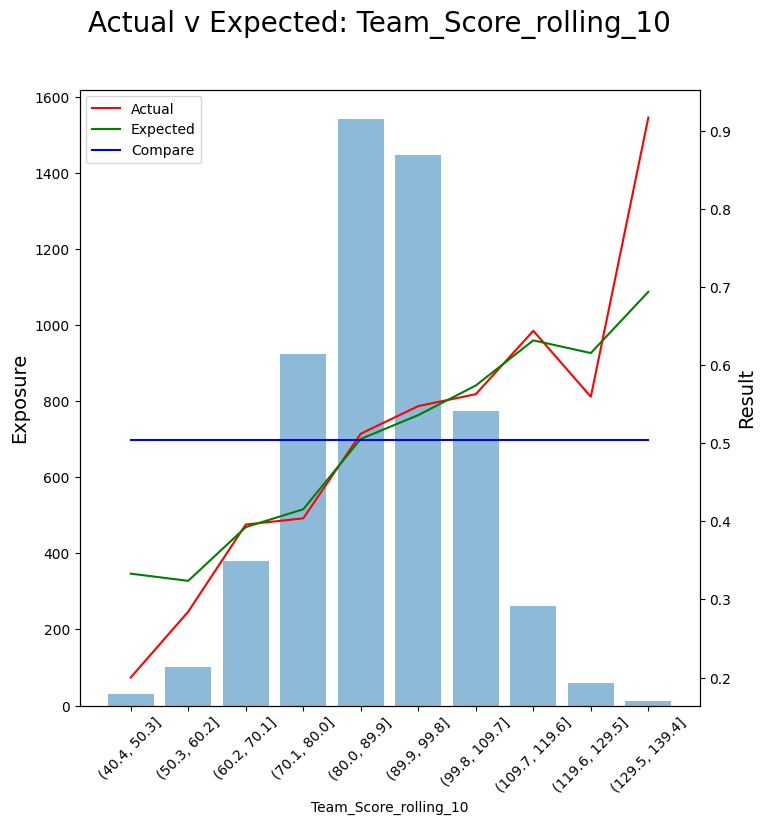

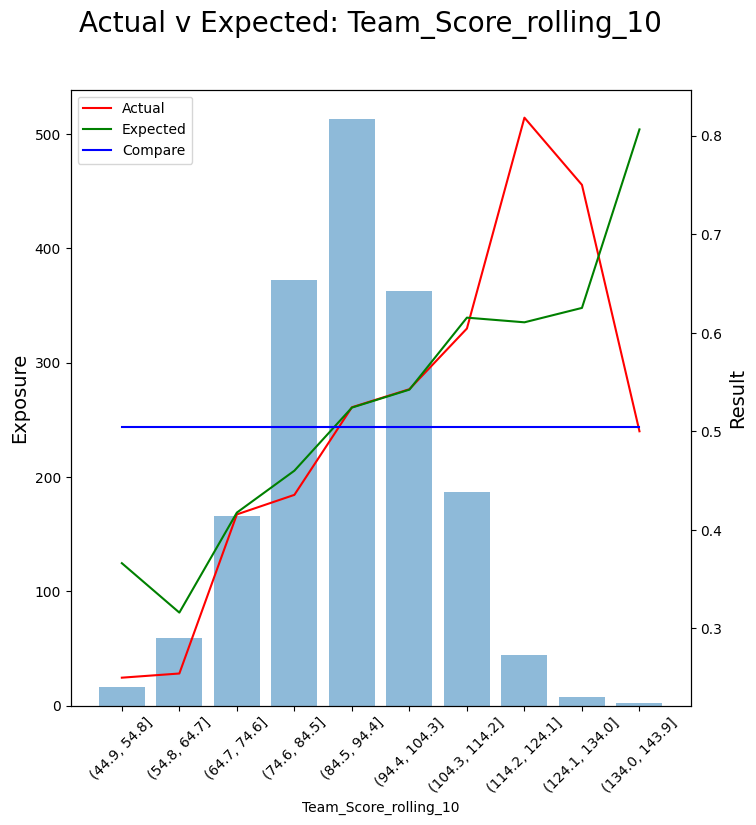

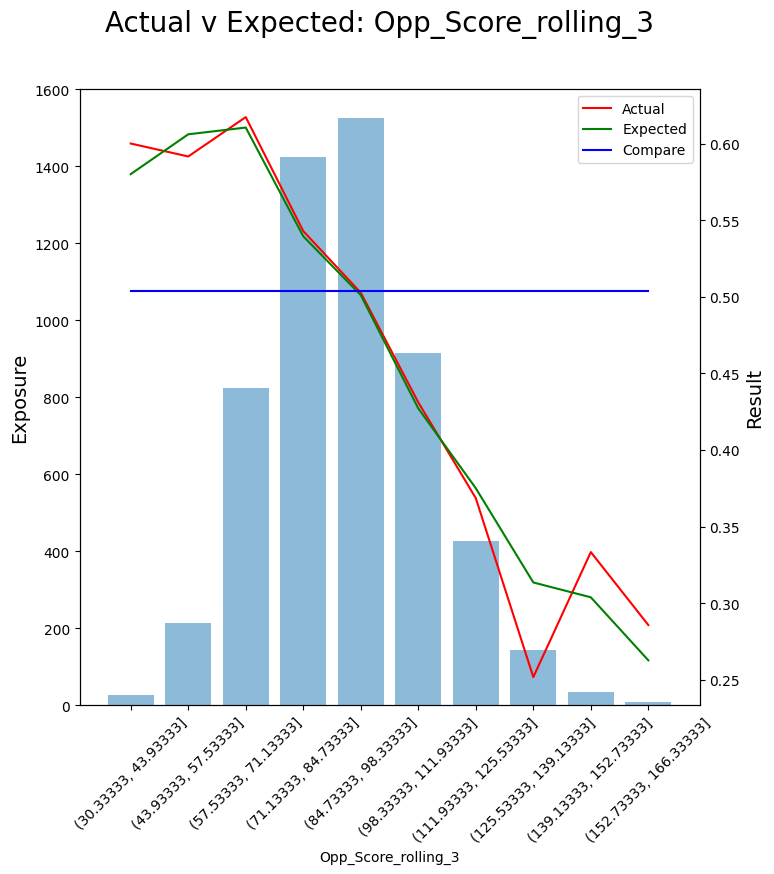

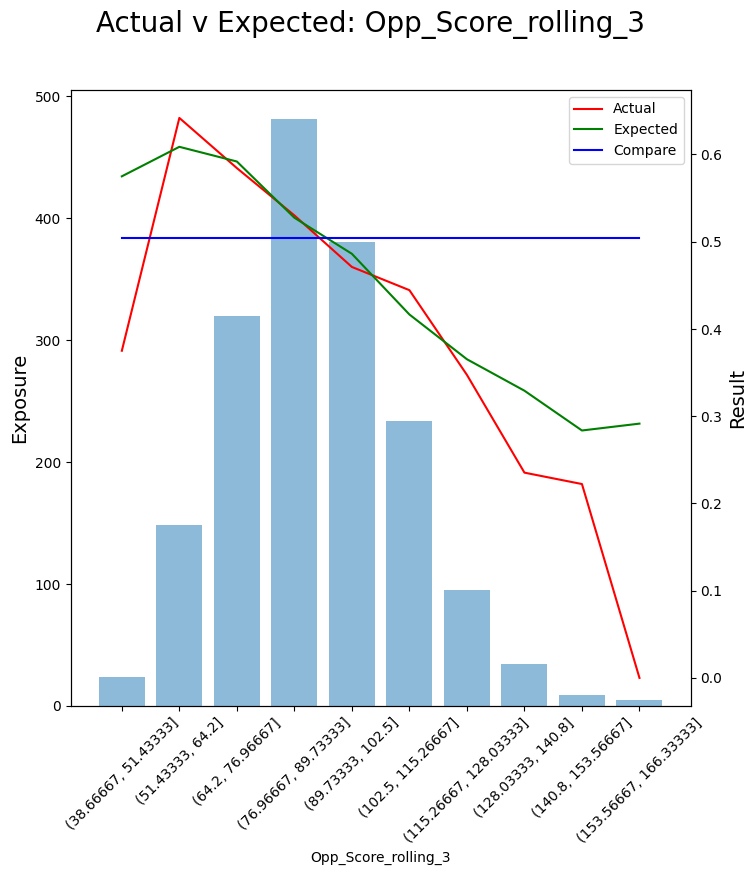

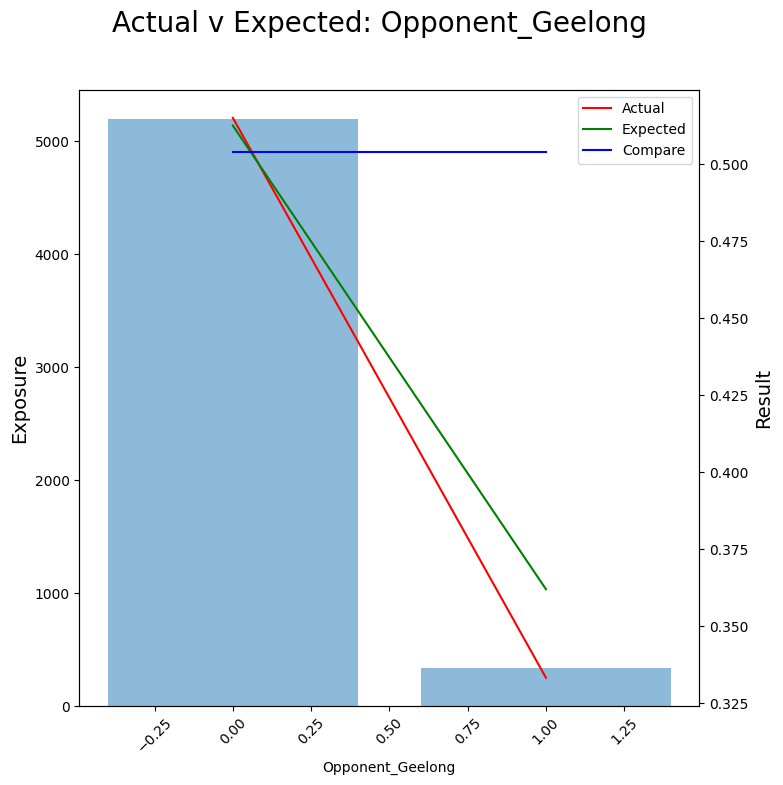

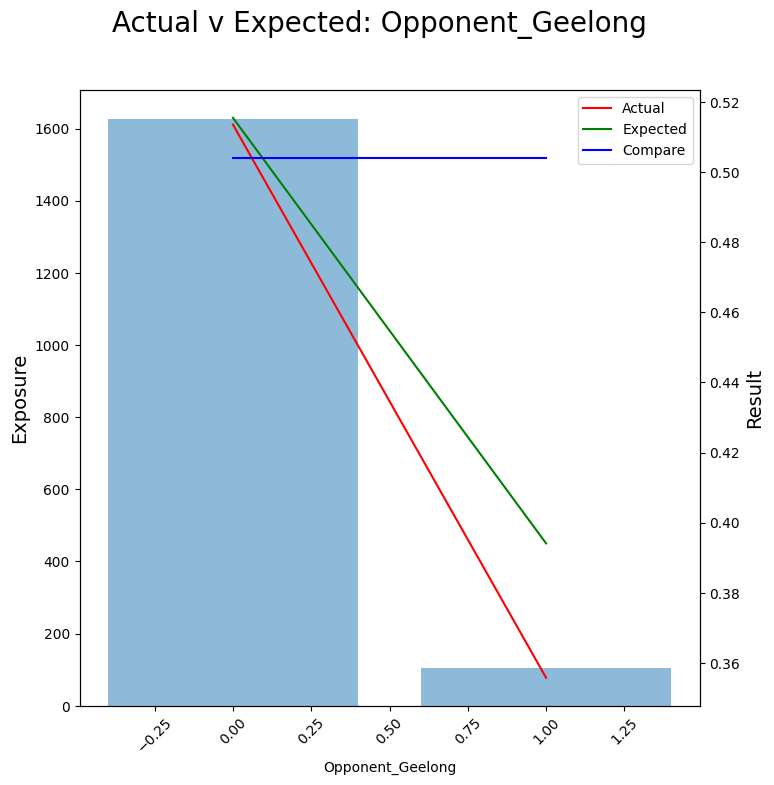

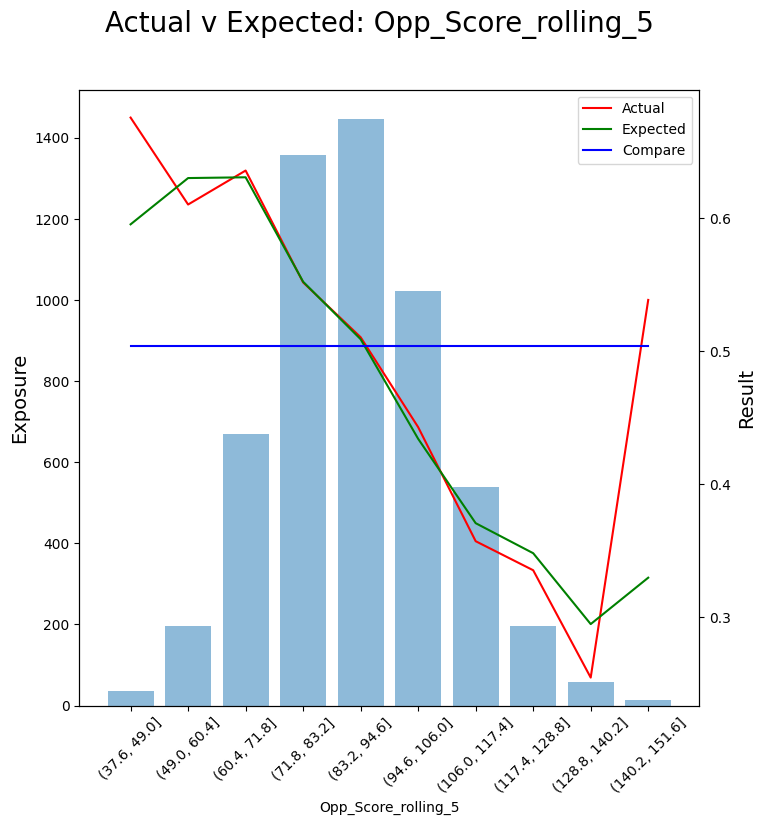

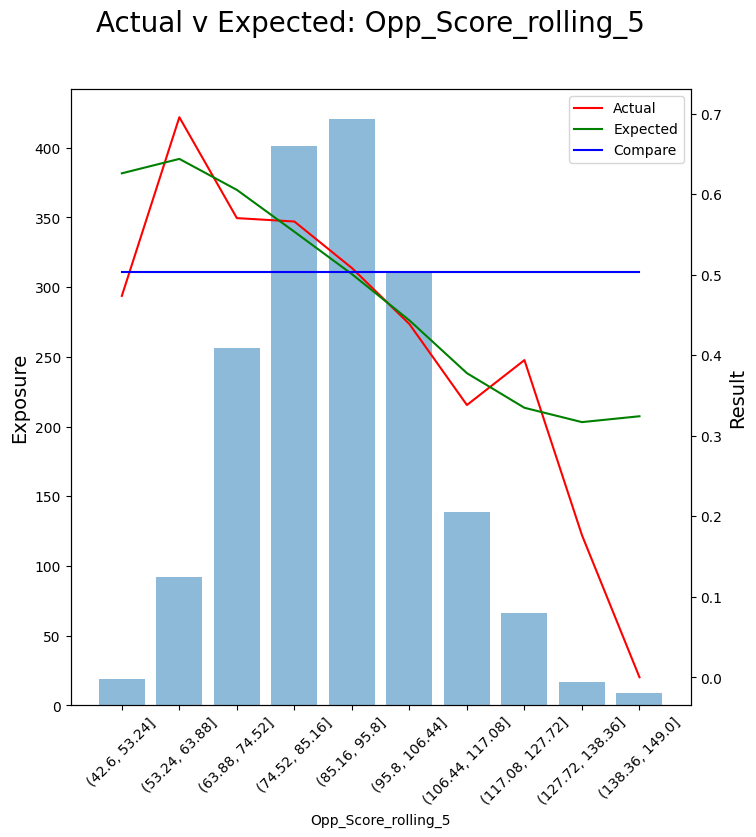

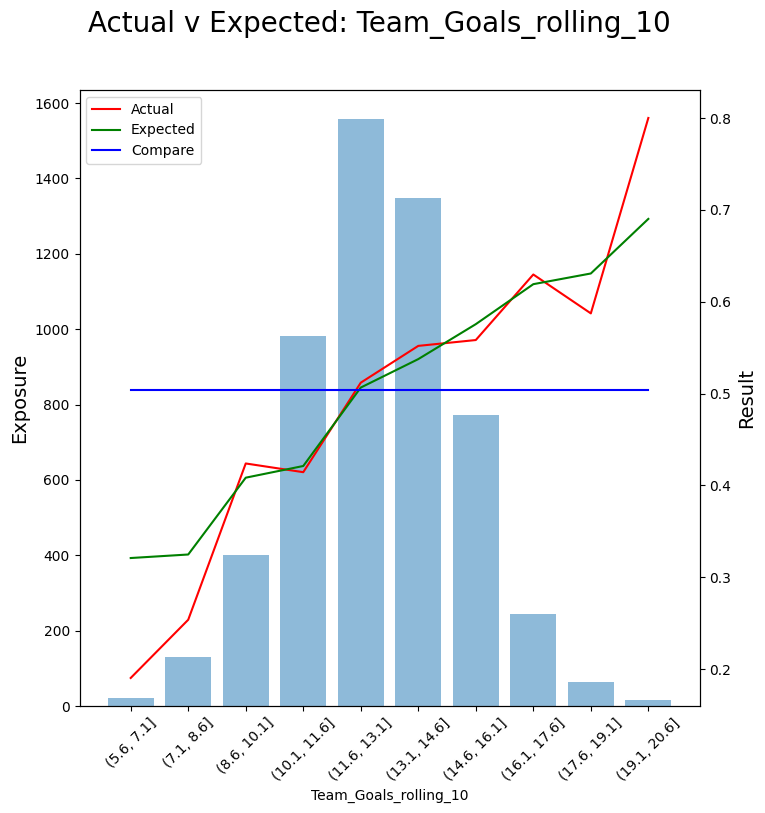

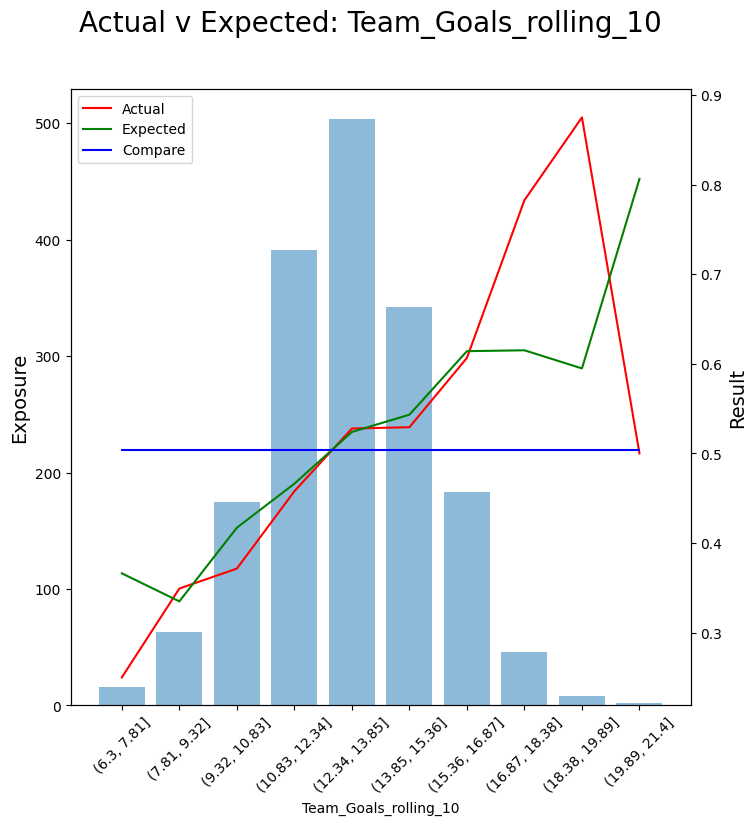

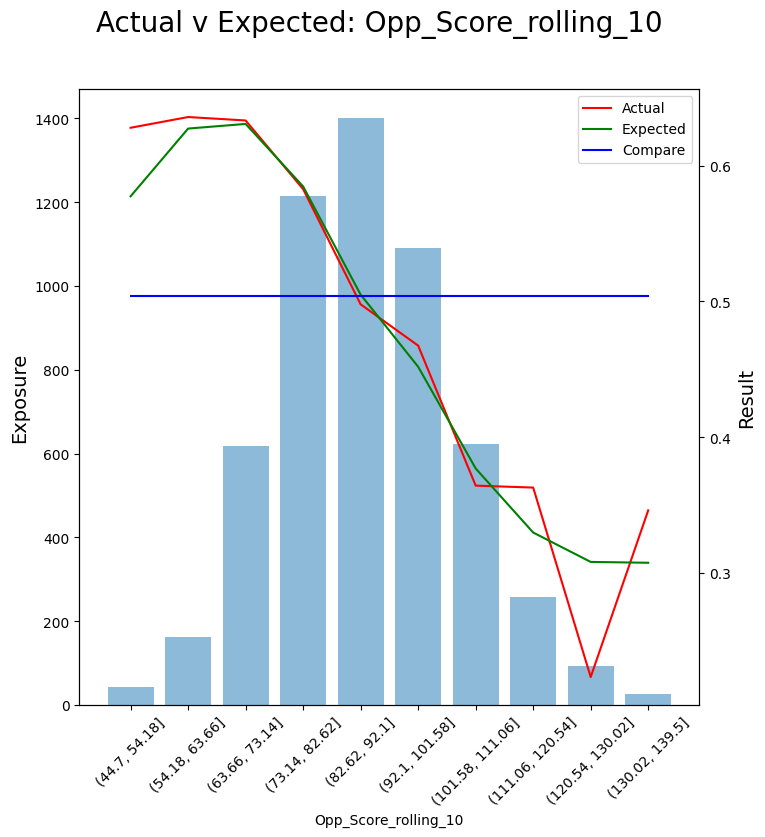

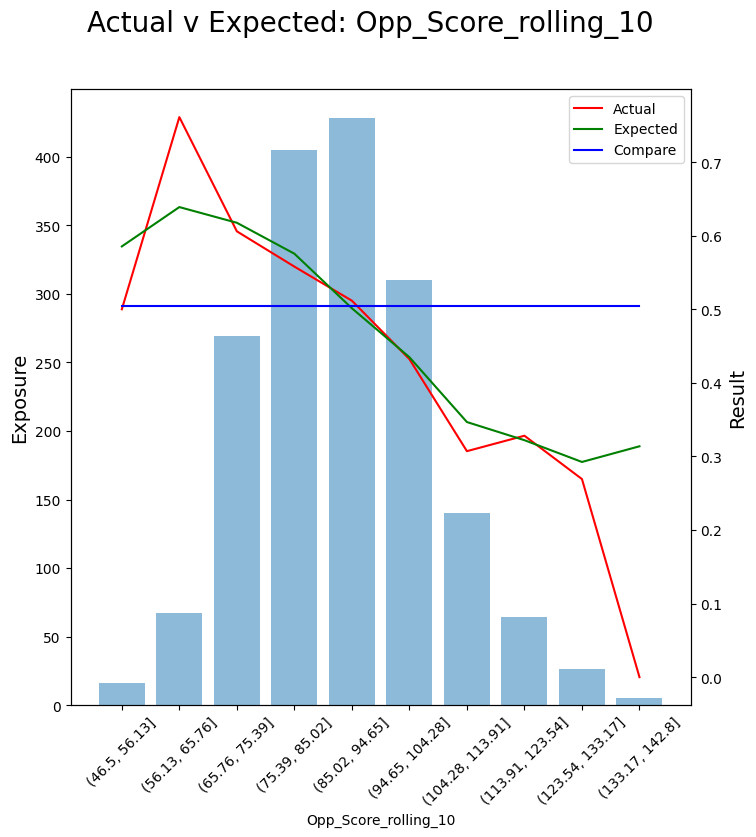

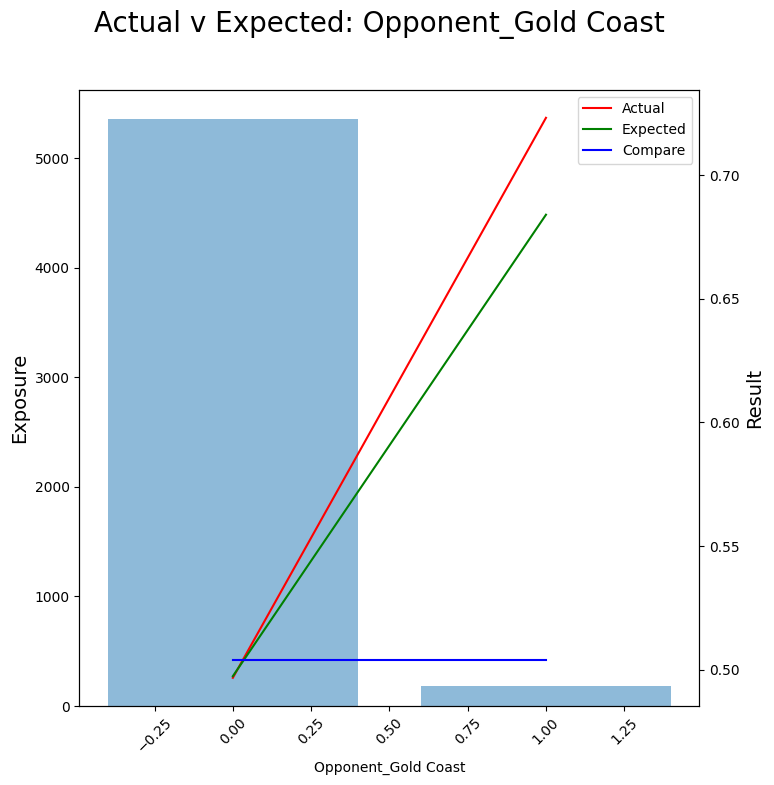

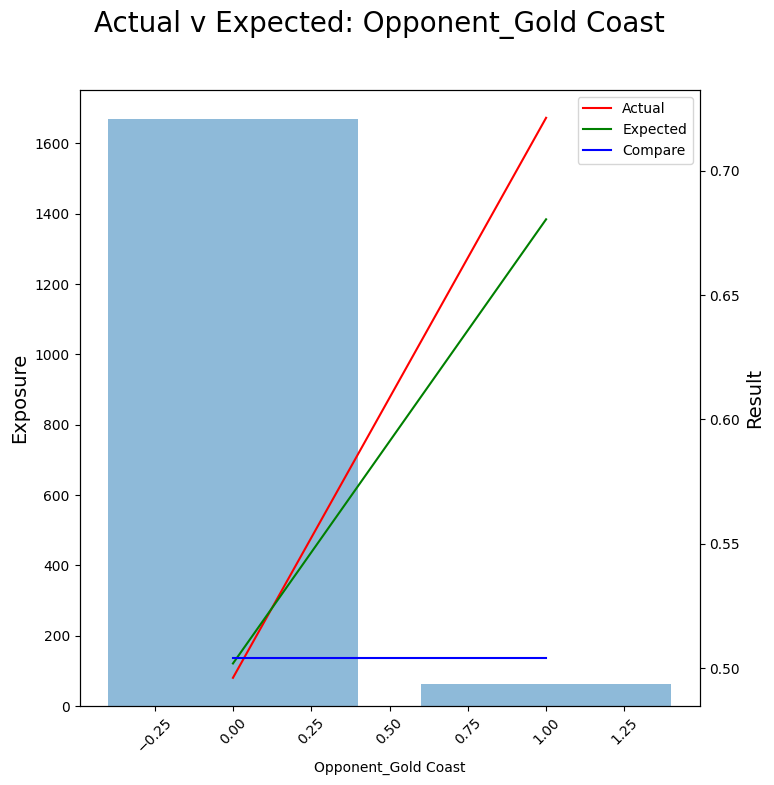

In [44]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Export and Save Pipeline

In [ ]:
# pipeline = Pipeline([
#     ('preprocessor', preproc),
#     ('model', super_xgb)
# ])
# pipeline.predict_proba(data, calibrate=True).mean(), pipeline.predict_proba(data, calibrate=False).mean()

In [ ]:
# joblib.dump(pipeline, "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-match-outcome-model/model_outputs/base_match_outcome_pipeline.joblib")